# Titanic: Machine Learning from Disaster

### Import Libraries

In [74]:
import random
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold

%matplotlib inline

### Load Data

In [2]:
df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

### Visualize data before cleanup

In [3]:
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Analysis and Cleanup

* https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-1-exploratory-data-analysis-with-pandas-de57880f1a68
* https://www.datacamp.com/community/tutorials/exploratory-data-analysis-python

In [4]:
# Shape of dataset, including generated columns
df.shape

(891, 12)

In [5]:
# What are our columns, again?
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [6]:
# General information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [7]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Missing Values

* https://analyticsindiamag.com/5-ways-handle-missing-values-machine-learning-datasets/

In [9]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### Cabin

Unfortunately, over 77% of Cabin info is missing in the dataset. Discarding data which does not have cabin data is out of the question. Also, survival may have been affected by which cabin a person was in and consequently which deck they were on, when the Titanic sank. While we could set it to a new value like `U`, a better way would be to analyse the deck structure of RMS Titanic and assign cabins by class.

A cursory read-through of how Titanic's cabins were organized in Wikipedia gives the following insights:
* A-Deck: It was reserved exclusively for First Class passengers
* B-Deck: More First Class passenger accommodations were located here 
* C-Deck: Crew Cabins
* D-Deck: First, Second and Third Class passengers had cabins on this deck
* E-Deck: The majority of E-Deck was occupied by Second-Class
* F-Deck: Second and Third Class passengers

So, let us assign decks based on a passenger's class in the following way:
* First Class: Random assignment beteween A and B Decks
* Second Class: Random assignment between D and E Decks
* Third Class: Random assignment between E, F and G Decks

While we are at it, let's also convert values in Cabin column to Decks, because that's a better feature for our analysis.

In [10]:
def clean_cabin(df):
    # Convert Cabins to Decks
    def convert_to_deck(cabin):
        if not pd.isna(cabin):
            cabin = cabin[0]
        return cabin

    df['Deck'] = df['Cabin'].apply(convert_to_deck)
    
    # Remove the odd value 'T' in Cabin/Deck
    df = df[df['Deck'] != 'T']
    
    # Random assignment of Decks for passengers with no Cabin info
    for i, row in df[df['Cabin'].isnull()].iterrows(): 
        if row['Pclass'] == 1:
            df.at[i, 'Deck'] = random.choice(['A', 'B'])
        elif row['Pclass'] == 2:
            df.at[i, 'Deck'] = random.choice(['D', 'E'])
        else:
            df.at[i, 'Deck'] = random.choice(['E', 'F', 'G'])
            
    # Drop cabin from the dataset
    df = df.drop('Cabin', axis=1)
    
    return df

#### Embarked

Most passengers boarded Titanic at Southampton (923, vs. 274 in Cherbourg and 123 in Queenstown). Let's just assign the missing `Embarked` values to `S` for Southampton.

In [11]:
def clean_embarked(df):
    # Update null values in Embarked to S
    df['Embarked'].fillna('S', inplace=True)
    
    # Also replace Embarked with numeric values
    df.loc[df['Embarked'] == 'S', 'Embarked'] = 0
    df.loc[df['Embarked'] == 'C', 'Embarked'] = 1
    df.loc[df['Embarked'] == 'Q', 'Embarked'] = 2

    return df

#### Age

The age of passengers is a very important attribute for our analysis, as Children were among the group of people onboard with a higher chance of survival (others being Women and Upper class). Removing records with no age information (~20% of the dataset) is not an option, neither is replacing the age with mean, median or mode. Let's use the age values we have from the other 80% of data to predict the missing 20%.

In [12]:
def clean_age(df):
    # Use Pandas Dataframe Interpolate to fill missing values!
    df = df.interpolate()
    
    # Or take the longer way to predict missing Age values
    if df['Age'].isnull().sum() > 0:
        linear = LinearRegression()

        data_with_null = df[df['Age'].isnull()][['PassengerId', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Age', 'Embarked']]
        data_without_null = df[['PassengerId', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Age', 'Embarked']].dropna()

        age_train_X = data_without_null.drop('Age', axis=1)
        age_train_y = data_without_null['Age']

        # FIXME - Does the presence of PassengerId affect fit?
        linear.fit(age_train_X, age_train_y)

        age_predicted = data_with_null
        age_test_X = data_with_null.drop('Age', axis=1)

        age_predicted['Age'] = linear.predict(age_test_X)

        # https://stackoverflow.com/questions/41773728/pandas-fill-na-with-data-from-another-dataframe-based-on-same-id
        df_cleaned = df.set_index("PassengerId").combine_first(age_predicted.set_index("PassengerId")).reset_index()

        # Set Negative age to a particular value, say 5 years
        df.loc[df['Age'] < 0., 'Age'] = 5
        
    return df

### Outliers

* https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/
* https://statinfer.com/104-3-5-box-plots-and-outlier-dectection-using-python/

#### Fare

{'whiskers': [<matplotlib.lines.Line2D at 0x11341e630>,
 'caps': [<matplotlib.lines.Line2D at 0x11341eef0>,
 'boxes': [<matplotlib.lines.Line2D at 0x11341e4e0>],
 'medians': [<matplotlib.lines.Line2D at 0x113433780>],
 'fliers': [<matplotlib.lines.Line2D at 0x113433ba8>],
 'means': []}

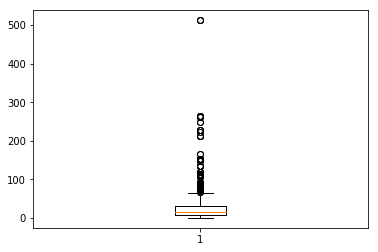

In [13]:
plt.boxplot(df['Fare'])

In [14]:
# Remove outliers in Fare values
# Get relevant percentiles and see their distribution
df['Fare'].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

0.0      0.0000
0.1      7.5500
0.2      7.8542
0.3      8.0500
0.4     10.5000
0.5     14.4542
0.6     21.6792
0.7     27.0000
0.8     39.6875
0.9     77.9583
1.0    512.3292
Name: Fare, dtype: float64

In [15]:
# Calculate 25th and 75th percentile, and the InterQuartile Range (IQR)
fare_q25, fare_q75 = np.percentile(df['Fare'], 25), np.percentile(df['Fare'], 75)
fare_iqr = fare_q75 - fare_q25
fare_iqr

23.0896

In [16]:
# Find the lower and upper limits
cutoff = fare_iqr * 10 # 10 is too high a value. Usually, values above or below 1.5 times IQR are deemed acceptable
lower, upper = max(fare_q25 - cutoff, 0), fare_q75 + cutoff
print("Lower: {}, Upper: {}".format(lower, upper))

Lower: 0, Upper: 261.896


In [17]:
# Observe Outliers
df[(df['Fare'] < lower) | (df['Fare'] > upper)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0000,C23 C25 C27,S
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,C
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.0000,C23 C25 C27,S
438,439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0000,C23 C25 C27,S
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C
742,743,1,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,C


On deeper analysis, the outlier fares seem to be valid and belonging to 3 ticket numbers. Let's keep all Fare values and not remove any outliers.

#### Age

/Users/subhashb/.pyenv/versions/3.6.5/envs/100-days/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/subhashb/.pyenv/versions/3.6.5/envs/100-days/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1872: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/Users/subhashb/.pyenv/versions/3.6.5/envs/100-days/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1879: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
/Users/subhashb/.pyenv/versions/3.6.5/envs/100-days/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1887: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
/Users/subhashb/.pyenv/versions/3.6.5/envs/100-days/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1888: RuntimeWarning: invalid value encountered in greater
  np.co

{'whiskers': [<matplotlib.lines.Line2D at 0x1134af7b8>,
 'caps': [<matplotlib.lines.Line2D at 0x11394e0b8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1134af390>],
 'medians': [<matplotlib.lines.Line2D at 0x11394e908>],
 'fliers': [<matplotlib.lines.Line2D at 0x11394ed30>],
 'means': []}

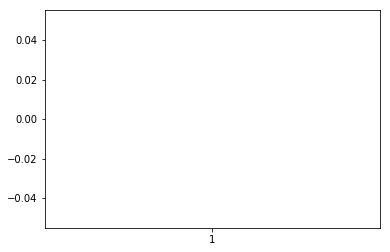

In [18]:
plt.boxplot(df['Age'])

**Age** seems to be distributed well, so let us not eliminate any outliers.

### Data Preparation

#### Sex

Change 'female' and 'male' values to 0 and 1 respectively.

In [19]:
def clean_sex(df):
    df['Sex'].replace({'female':0,'male':1},inplace=True)
    
    return df

#### Deck

Change A-G decks with numeric values

In [20]:
def clean_deck(df):
    df['Deck'].replace(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'], [0, 1, 2, 3, 4, 5, 6, 7], inplace=True)
    return df

#### Miscellaneous columns

Drop **PassengerId**, **Ticket** and **Name** columns

In [21]:
def clean_unnecessary_columns(df):
    df = df.drop(['Name', 'PassengerId', 'Ticket'], axis=1)
    return df

In [22]:
def clean_all(df):
    df = clean_cabin(df)
    df = clean_embarked(df)
    df = clean_age(df)
    df = clean_sex(df)
    df = clean_deck(df)
    df = clean_unnecessary_columns(df)
    
    return df

In [23]:
df = clean_all(df)

In [24]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck
0,0,3,1,22.0,1,0,7.2500,0,6
1,1,1,0,38.0,1,0,71.2833,1,2
2,1,3,0,26.0,0,0,7.9250,0,6
3,1,1,0,35.0,1,0,53.1000,0,2
4,0,3,1,35.0,0,0,8.0500,0,6


In [25]:
# Separate data and target values
y = df['Survived']
df = df.drop('Survived', axis=1)

## Feature Selection

* https://machinelearningmastery.com/feature-selection-machine-learning-python/

### Univariate Selection

In [26]:
kbest = SelectKBest(score_func=chi2, k=4)
kbest_fit = kbest.fit(df, y)

# Summarize Scores
pd.options.display.float_format = "{:.2f}".format
print(kbest_fit.scores_)

features = kbest_fit.transform(df)
print(features[0:5,:])

[3.11295582e+01 9.26007474e+01 2.16936333e+01 2.64263585e+00
 9.98961888e+00 4.52407258e+03 1.12413776e+01 3.41879218e+01]
[[ 3.      1.      7.25    6.    ]
 [ 1.      0.     71.2833  2.    ]
 [ 3.      0.      7.925   6.    ]
 [ 1.      0.     53.1     2.    ]
 [ 3.      1.      8.05    6.    ]]


In [27]:
# Determine which features were chosen
mask = kbest_fit.get_support() #list of booleans
univariate_new_features = [] # The list of your K best features
feature_names = list(df.columns.values)

for bool, feature in zip(mask, feature_names):
    if bool:
        univariate_new_features.append(feature)

In [28]:
univariate_new_features

['Pclass', 'Sex', 'Fare', 'Deck']

### Recursive Feature Elimination

In [29]:
linear_model = LinearRegression()
rfe = RFE(linear_model, 4)
rfe_fit = rfe.fit(df, y)
print("Num Features: %d" % (rfe_fit.n_features_))
print("Selected Features: %s" % (rfe_fit.support_))
print("Feature Ranking: %s" % (rfe_fit.ranking_))

Num Features: 4
Selected Features: [ True  True False  True False False  True False]
Feature Ranking: [1 1 4 1 3 5 1 2]


/Users/subhashb/.pyenv/versions/3.6.5/envs/100-days/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [30]:
# Determine which features were chosen
mask = rfe_fit.support_ #list of booleans
recursive_new_features = [] # The list of your K best features
feature_names = list(df.columns.values)

for bool, feature in zip(mask, feature_names):
    if bool:
        recursive_new_features.append(feature)

In [31]:
recursive_new_features

['Pclass', 'Sex', 'SibSp', 'Embarked']

### PCA

In [32]:
pca = PCA(n_components=4)
pca_fit = pca.fit(df, y)

print("Explained Variance: %s" % (pca_fit.explained_variance_ratio_))
print("Components:", pca_fit.components_)

Explained Variance: [9.26416105e-01 7.18381166e-02 8.33508603e-04 4.49437840e-04]
Components: [[-9.27635955e-03 -1.74827354e-03  2.64189287e-02  3.50431539e-03
   3.48325718e-03  9.99463777e-01  7.96631154e-04 -1.61258860e-02]
 [-1.53699385e-02  2.70250566e-03  9.98958042e-01 -1.83935673e-02
  -1.11909643e-02 -2.68532871e-02  9.83698722e-04 -2.55668634e-02]
 [ 3.60608374e-01 -7.32271819e-03  3.44080549e-02  2.21753945e-01
   1.28816829e-01  1.56259566e-02  2.67751283e-02  8.95541400e-01]
 [-7.53992437e-02 -5.85935476e-02  1.31987956e-02  8.79624567e-01
   3.87838953e-01 -9.40887516e-03 -9.06071413e-02 -2.41352294e-01]]


### Feature Importance

In [33]:
extra_trees_model = ExtraTreesClassifier()
extra_trees_model.fit(df, y)

print(extra_trees_model.feature_importances_)

[0.08013477 0.26599251 0.24734799 0.04252159 0.04540781 0.21612114
 0.03651952 0.06595466]


## Models and Predictions

### Neural Networks

#### Split into Training and Test data

Split data simplistically into training and test datasets

In [34]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=21)

#### Fit Model

In [35]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [36]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [37]:
mlp = MLPClassifier(hidden_layer_sizes=(30, 30, 30))
mlp.fit(X_train, y_train)

/Users/subhashb/.pyenv/versions/3.6.5/envs/100-days/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(30, 30, 30), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [38]:
pred = mlp.predict(X_test)

In [39]:
print(confusion_matrix(y_test, pred))

[[94  6]
 [27 51]]


In [40]:
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.78      0.94      0.85       100
          1       0.89      0.65      0.76        78

avg / total       0.83      0.81      0.81       178



### Neural Networks - with selected features

#### Univariate Features

In [41]:
df_univariate_features = df[univariate_new_features]

##### Split into Training and Test Data

In [42]:
X_train, X_test, y_train, y_test = train_test_split(df_univariate_features, y, test_size=0.2, random_state=21)

##### Fit Model

In [43]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

mlp = MLPClassifier(hidden_layer_sizes=(30, 30, 30))
mlp.fit(X_train, y_train)

pred = mlp.predict(X_test)

print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.79      0.95      0.86       100
          1       0.91      0.67      0.77        78

avg / total       0.84      0.83      0.82       178



#### Recursive Features

In [44]:
df_recursive_features = df[recursive_new_features]

##### Split into Training and Test Data

In [45]:
X_train, X_test, y_train, y_test = train_test_split(df_recursive_features, y, test_size=0.2, random_state=21)

##### Fit Model

In [46]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

mlp = MLPClassifier(hidden_layer_sizes=(30, 30, 30))
mlp.fit(X_train, y_train)

pred = mlp.predict(X_test)

print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.76      0.96      0.85       100
          1       0.92      0.62      0.74        78

avg / total       0.83      0.81      0.80       178



#### PCA

In [47]:
pca = PCA(n_components=4)
df_pca = pca.fit_transform(df)

##### Split into Training and Test Data

In [48]:
X_train, X_test, y_train, y_test = train_test_split(df_pca, y, test_size=0.2, random_state=21)

##### Fit Model

In [49]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

mlp = MLPClassifier(hidden_layer_sizes=(30, 30, 30), random_state=21)
mlp.fit(X_train, y_train)

pred = mlp.predict(X_test)

print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.69      0.87      0.77       100
          1       0.75      0.50      0.60        78

avg / total       0.72      0.71      0.70       178



### Neural Networks with Cross Validation

In [50]:
kf = KFold(n_splits=10)
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(30,30,30), random_state=21)

for train_indices, test_indices in kf.split(df):
    clf.fit(df.iloc[train_indices], y.iloc[train_indices])
    print(clf.score(df.iloc[test_indices], y.iloc[test_indices]))

0.7865168539325843
0.7303370786516854
0.7865168539325843
0.8314606741573034
0.7415730337078652
0.797752808988764
0.7640449438202247
0.7865168539325843
0.8539325842696629
0.8089887640449438


### Generate Predictions

In [51]:
cleaned_test_df = clean_all(test_df)
predictions = clf.predict(cleaned_test_df)

In [52]:
cleaned_test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck
0,3,1,34.50,0,0,7.83,2,5
1,3,0,47.00,1,0,7.00,0,4
2,2,1,62.00,0,0,9.69,2,4
3,3,1,27.00,0,0,8.66,0,4
4,3,0,22.00,1,1,12.29,0,6


## Output CSV

In [75]:
with open('survival.csv', 'w') as output_file:
    csv_out = csv.writer(output_file)
    csv_out.writerow(['PassengerId', 'Survived'])
    for i, row in cleaned_test_df.iterrows():
        csv_out.writerow((test_df.iloc[i]['PassengerId'], predictions[i]))